In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'dogsvcats/train'
TEST_DIR = 'dogsvcats/test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvcats-{}-{}.model'.format(LR, '6conv-basic-video')

In [2]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat' : return [1,0]
    elif word_label == 'dog' : return [0,1]

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data
        

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    
    np.save('test_data.npy', testing_data)
    return testing_data



In [5]:
train_data = create_train_data()
# if already have trained data
# train_data = np.load('train_data.npy')



100%|██████████| 25000/25000 [00:20<00:00, 1243.04it/s]


In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf

tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)


convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)


convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)


convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

curses is not supported on this machine (please install/reinstall curses for an optimal experience)








Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







In [7]:
# if os.path.exists('{}.meta'.format(MODEL_NAME)):
#     model.load(MODEL_NAME)
#     print("model loaded")



In [8]:
train = train_data[:-500]
test = train_data[-500:]



In [9]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [10]:
# Train the network
model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)
# tensorboard --logdir="C:\Users\djenz\OneDrive - University of Vermont\Machine-Learning-Final-Project\CNN TUT\log"

Training Step: 3829  | total loss: 0.37800 | time: 4.256s
| Adam | epoch: 010 | loss: 0.37800 - acc: 0.8171 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.38945 | time: 5.267s
| Adam | epoch: 010 | loss: 0.38945 - acc: 0.8104 | val_loss: 0.44003 - val_acc: 0.8140 -- iter: 24500/24500
--


In [11]:
model.save(MODEL_NAME)


INFO:tensorflow:C:\Users\djenz\OneDrive - University of Vermont\Machine-Learning-Final-Project\CNN TUT\dogsvcats-0.001-6conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


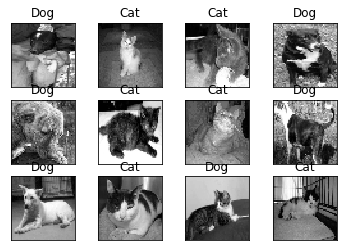

In [15]:
import matplotlib.pyplot as plt

# if you don't have this file yet
#test_data = process_test_data()
#if you already have it
test_data = np.load('test_data.npy', allow_pickle=True)

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    # cat : [1,0]
    # dog : [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label="Dog"
    else: str_label="Cat"
    
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
    

In [13]:
with open('submission-file.csv','w') as f:
    f.write('id,label\n')



In [14]:
with open('submission-file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))
        
        



100%|██████████| 12500/12500 [00:13<00:00, 953.39it/s]
